Training models...

Evaluating models with cross-validation...

Fall Detection Cross-Validation Scores (f1):
[1.         1.         1.         1.         0.99858557]
Mean f1: 0.9997
Std Dev: 0.0006

Fall Severity Cross-Validation Scores (f1_weighted):
[0.70248304 0.68855423 0.68330952 0.71055472 0.69376947]
Mean f1_weighted: 0.6957
Std Dev: 0.0097

Fall Direction Cross-Validation Scores (f1_weighted):
[0.71357114 0.6642448  0.73848871 0.70990385 0.7073063 ]
Mean f1_weighted: 0.7067
Std Dev: 0.0240

Impact Force Cross-Validation Scores (r2):
[0.97078088 0.95250489 0.96823684 0.95761184 0.96078586]
Mean r2: 0.9620
Std Dev: 0.0067

Activity State Cross-Validation Scores (f1_weighted):
[0.69385898 0.70811187 0.75843127 0.72893791 0.74498488]
Mean f1_weighted: 0.7269
Std Dev: 0.0235

Final Evaluation on Test Set:

Fall Detection Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       768
         1.0       1.00      1.0

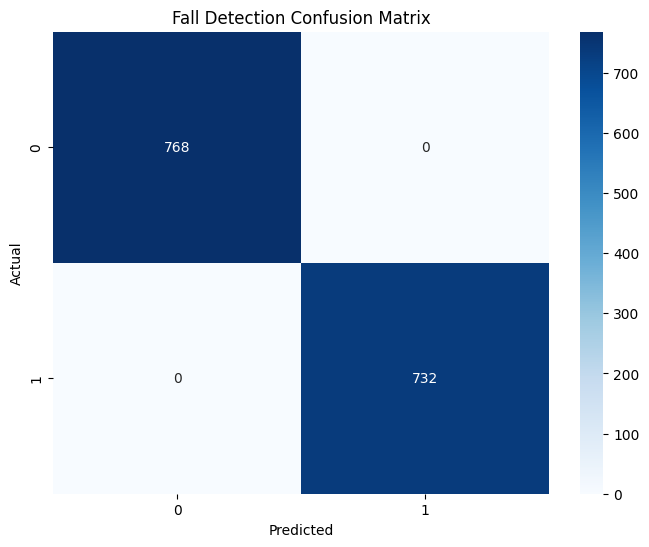

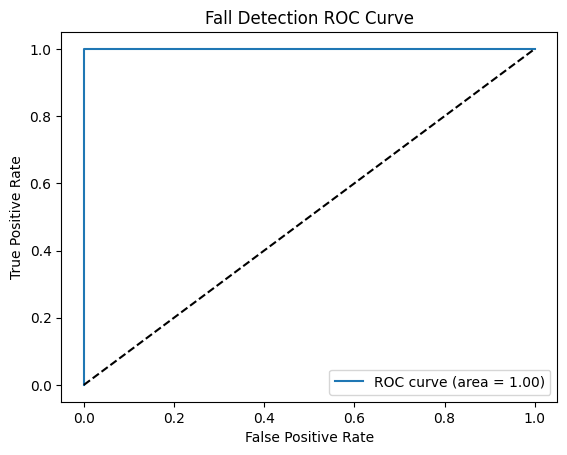

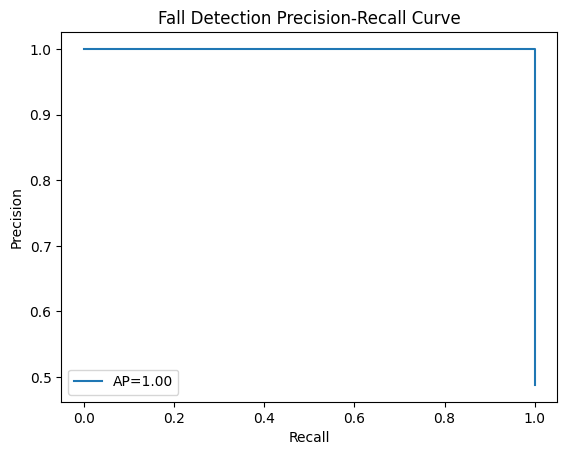


Fall Severity Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       768
           1       0.29      0.13      0.18       250
           2       0.46      0.79      0.58       336
           3       0.11      0.03      0.05       146

    accuracy                           0.71      1500
   macro avg       0.46      0.49      0.45      1500
weighted avg       0.67      0.71      0.68      1500



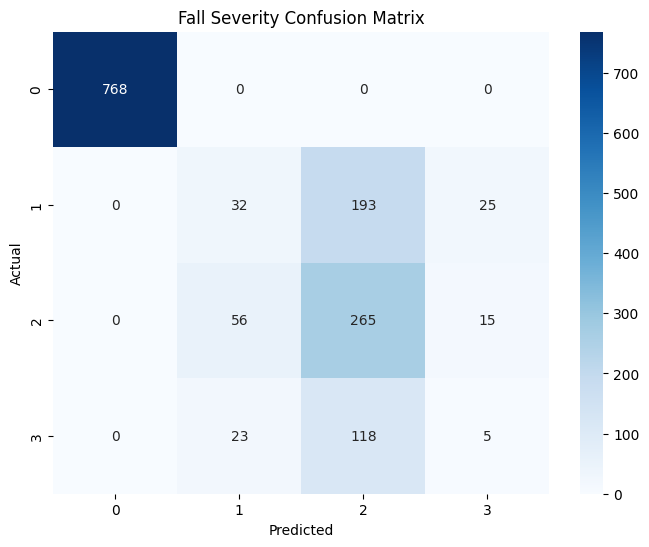


Fall Direction Classification Report:
              precision    recall  f1-score   support

           0       0.08      0.20      0.11       178
           1       0.26      0.19      0.22       205
           2       0.22      0.33      0.26       160
           3       0.00      0.00      0.00       768
           4       0.08      0.28      0.12       189

    accuracy                           0.12      1500
   macro avg       0.13      0.20      0.14      1500
weighted avg       0.08      0.12      0.09      1500



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



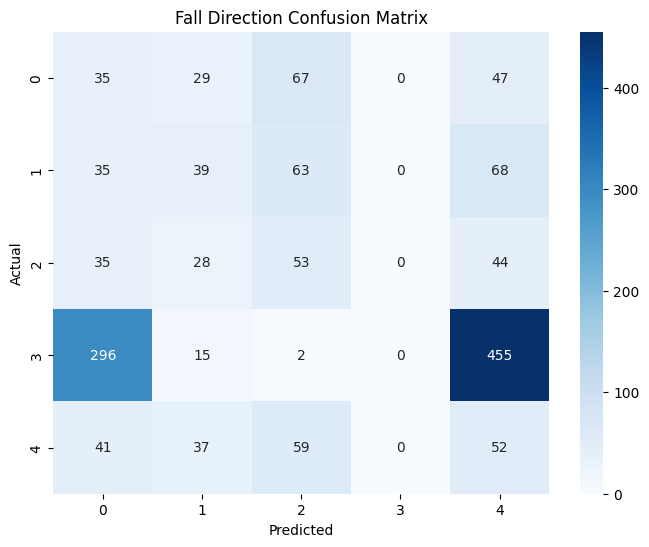


Impact Force Regression Metrics:
MSE: 0.1354
RMSE: 0.3680
R2 Score: 0.9673


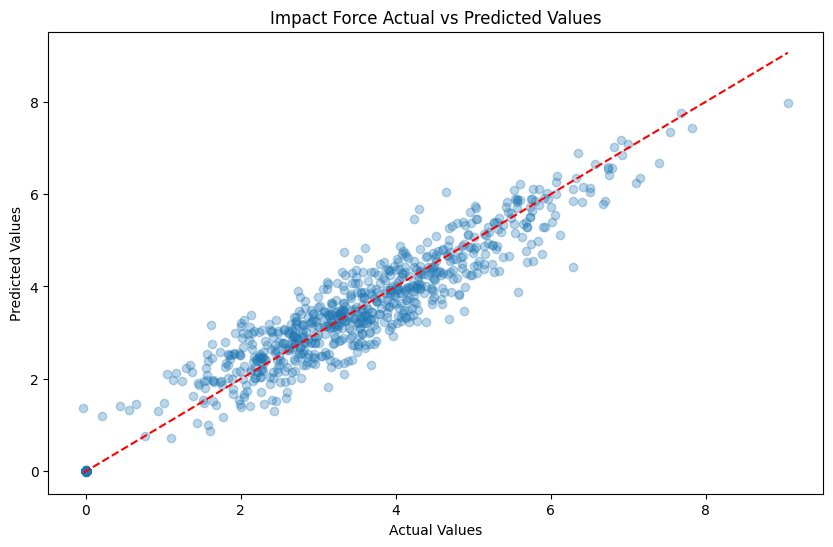

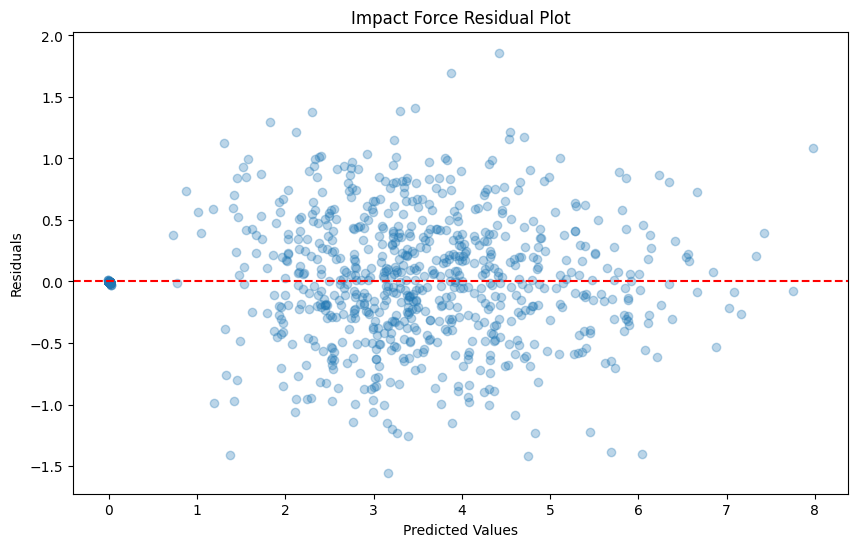


Activity State Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       732
           1       0.32      0.25      0.28       258
           2       0.29      0.06      0.09       253
           3       0.32      0.65      0.43       257

    accuracy                           0.65      1500
   macro avg       0.48      0.49      0.45      1500
weighted avg       0.65      0.65      0.63      1500



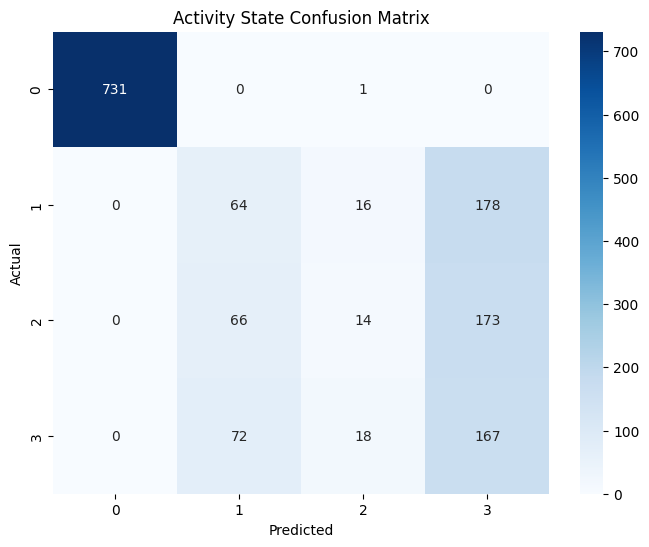


Plotting feature importance...



Launching Interactive Predictor...



Models saved to 'fall_detection_models.pkl'


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import (classification_report, confusion_matrix,
                           roc_curve, auc, mean_squared_error,
                           r2_score, accuracy_score, precision_recall_curve,
                           average_precision_score)
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display
def generate_fall_data(n_samples=5000):
    np.random.seed(42)

    # Base features
    data = {
        'AccX': np.concatenate([np.random.normal(0.1, 0.05, n_samples//2),
                               np.random.normal(2.5, 1.2, n_samples//2)]),
        'AccY': np.concatenate([np.random.normal(0.2, 0.1, n_samples//2),
                               np.random.normal(-1.8, 0.9, n_samples//2)]),
        'AccZ': np.concatenate([np.random.normal(9.8, 0.5, n_samples//2),
                               np.random.normal(3.2, 2.5, n_samples//2)]),
        'GyroX': np.concatenate([np.random.normal(0, 0.1, n_samples//2),
                                np.random.normal(1.5, 0.8, n_samples//2)]),
        'GyroY': np.concatenate([np.random.normal(0, 0.1, n_samples//2),
                                np.random.normal(-2.0, 1.2, n_samples//2)]),
        'GyroZ': np.concatenate([np.random.normal(0, 0.1, n_samples//2),
                                np.random.normal(0.5, 0.3, n_samples//2)]),
        'Pressure': np.random.normal(101325, 100, n_samples)
    }

    df = pd.DataFrame(data)
    # Derived features
    df['AccMag'] = np.sqrt(df['AccX']**2 + df['AccY']**2 + df['AccZ']**2)
    df['GyroMag'] = np.sqrt(df['GyroX']**2 + df['GyroY']**2 + df['GyroZ']**2)
    df['Jerk'] = df['AccMag'].diff().abs().fillna(0)

    # Prediction targets
    df['Fall_Detected'] = np.concatenate([np.zeros(n_samples//2), np.ones(n_samples//2)])
    # The size of the random choices array was changed to match the condition array
    df['Fall_Severity'] = np.where(df['Fall_Detected'] == 1,
                                 np.random.choice([1, 2, 3], size=n_samples, p=[0.3, 0.5, 0.2]),
                                 0)
    df['Fall_Direction'] = np.where(df['Fall_Detected'] == 1,
                                  np.random.choice(['Forward', 'Backward', 'Left', 'Right'], size=n_samples),
                                  'None')
    df['Impact_Force'] = np.where(df['Fall_Detected'] == 1,
                                df['AccMag'] * 0.7 + np.random.normal(0, 0.5, n_samples),
                                0)
    df['Activity_State'] = np.where(df['Fall_Detected'] == 1,
                                  'Falling',
                                  np.random.choice(['Walking', 'Standing', 'Sitting'], size=n_samples))

    return df
    # Generate and prepare data
df = generate_fall_data()

# Feature engineering
features = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ',
            'AccMag', 'GyroMag', 'Jerk', 'Pressure']
X = df[features]

# Encode categorical targets
le_direction = LabelEncoder()
df['Fall_Direction_Encoded'] = le_direction.fit_transform(df['Fall_Direction'])

le_activity = LabelEncoder()
df['Activity_State_Encoded'] = le_activity.fit_transform(df['Activity_State'])

# Define all prediction targets
y_detection = df['Fall_Detected']
y_severity = df['Fall_Severity']
y_direction = df['Fall_Direction_Encoded']
y_impact = df['Impact_Force']
y_activity = df['Activity_State_Encoded']

# Train-test split (single split for consistency)
X_train, X_test, y_train_det, y_test_det, y_train_sev, y_test_sev, \
y_train_dir, y_test_dir, y_train_imp, y_test_imp, y_train_act, y_test_act = train_test_split(
    X, y_detection, y_severity, y_direction, y_impact, y_activity,
    test_size=0.3, random_state=42
)

# Apply SMOTE to handle class imbalance for classification tasks
smote = SMOTE(random_state=42)
X_train_det, y_train_det = smote.fit_resample(X_train, y_train_det)  # Fall detection
X_train_dir, y_train_dir = smote.fit_resample(X_train, y_train_dir)  # Fall direction
X_train_act, y_train_act = smote.fit_resample(X_train, y_train_act)  # Activity state

# Standardize features for models that benefit from it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_det_scaled = scaler.fit_transform(X_train_det)
X_train_dir_scaled = scaler.fit_transform(X_train_dir)
X_train_act_scaled = scaler.fit_transform(X_train_act)
# Model Training Functions with hyperparameter tuning
def train_fall_detection_model(X_train, y_train):
    model = XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(X_train, y_train)
    return model

def train_severity_model(X_train, y_train):
    model = XGBClassifier(
        objective='multi:softmax',
        num_class=4,
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    )
    model.fit(X_train, y_train)
    return model

def train_direction_model(X_train, y_train):
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        class_weight='balanced',
        random_state=42
    )
    model.fit(X_train, y_train)
    return model

def train_impact_model(X_train, y_train):
    model = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=150,
        max_depth=6,
        learning_rate=0.05,
        random_state=42
    )
    model.fit(X_train, y_train)
    return model

def train_activity_model(X_train, y_train):
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        class_weight='balanced',
        random_state=42
    )
    model.fit(X_train, y_train)
    return model

# Train all models
print("Training models...")
detection_model = train_fall_detection_model(X_train_det_scaled, y_train_det)
severity_model = train_severity_model(X_train_scaled, y_train_sev)
direction_model = train_direction_model(X_train_dir_scaled, y_train_dir)
impact_model = train_impact_model(X_train_scaled, y_train_imp)
activity_model = train_activity_model(X_train_act_scaled, y_train_act)

# Enhanced Evaluation Functions
def evaluate_classification_model(model, X_test, y_test, model_name=""):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    plt.figure(figsize=(8,6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=model.classes_ if hasattr(model, 'classes_') else None,
               yticklabels=model.classes_ if hasattr(model, 'classes_') else None)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve for binary classification
    if y_proba is not None and len(np.unique(y_test)) == 2:
        fpr, tpr, _ = roc_curve(y_test, y_proba[:,1])
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} ROC Curve')
        plt.legend()
        plt.show()

        # Precision-Recall curve
        precision, recall, _ = precision_recall_curve(y_test, y_proba[:,1])
        avg_precision = average_precision_score(y_test, y_proba[:,1])

        plt.figure()
        plt.plot(recall, precision, label=f'AP={avg_precision:.2f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'{model_name} Precision-Recall Curve')
        plt.legend()
        plt.show()

def evaluate_regression_model(model, X_test, y_test, model_name=""):
    y_pred = model.predict(X_test)

    print(f"\n{model_name} Regression Metrics:")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
    print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")

    plt.figure(figsize=(10,6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_name} Actual vs Predicted Values')
    plt.show()

    residuals = y_test - y_pred
    plt.figure(figsize=(10,6))
    plt.scatter(y_pred, residuals, alpha=0.3)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} Residual Plot')
    plt.show()

# Evaluate all models with cross-validation
print("\nEvaluating models with cross-validation...")

def cross_validate_model(model, X, y, model_name="", scoring='accuracy'):
    scores = cross_val_score(model, X, y, cv=5, scoring=scoring)
    print(f"\n{model_name} Cross-Validation Scores ({scoring}):")
    print(scores)
    print(f"Mean {scoring}: {np.mean(scores):.4f}")
    print(f"Std Dev: {np.std(scores):.4f}")

cross_validate_model(detection_model, X_train_det_scaled, y_train_det, "Fall Detection", 'f1')
cross_validate_model(severity_model, X_train_scaled, y_train_sev, "Fall Severity", 'f1_weighted')
cross_validate_model(direction_model, X_train_dir_scaled, y_train_dir, "Fall Direction", 'f1_weighted')
cross_validate_model(impact_model, X_train_scaled, y_train_imp, "Impact Force", 'r2')
cross_validate_model(activity_model, X_train_act_scaled, y_train_act, "Activity State", 'f1_weighted')

# Final evaluation on test set
print("\nFinal Evaluation on Test Set:")
evaluate_classification_model(detection_model, X_test_scaled, y_test_det, "Fall Detection")
evaluate_classification_model(severity_model, X_test_scaled, y_test_sev, "Fall Severity")
evaluate_classification_model(direction_model, X_test_scaled, y_test_dir, "Fall Direction")
evaluate_regression_model(impact_model, X_test_scaled, y_test_imp, "Impact Force")
evaluate_classification_model(activity_model, X_test_scaled, y_test_act, "Activity State")

# Feature Importance Visualization
!pip install plotly
import plotly.express as px # import the module here
def plot_feature_importance(models_dict):
    fig = make_subplots(
        rows=2, cols=3,
        subplot_titles=(
            "Fall Detection", "Fall Severity", "Fall Direction",
            "Impact Force", "Activity State", "Combined Importance"
        )
    )

    # Initialize combined importance
    combined_importance = pd.Series(0, index=features)

    # Plot importance for each model
    for i, (name, model) in enumerate(models_dict.items()):
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importance = np.abs(model.coef_[0])
        else:
            continue

        importance_series = pd.Series(importance, index=features)
        combined_importance += importance_series

        row = (i // 3) + 1
        col = (i % 3) + 1

        fig.add_trace(
            go.Bar(
                x=features,
                y=importance_series,
                name=name,
                marker_color=px.colors.qualitative.Plotly[i] # use px here
            ),
            row=row, col=col
        )

    # Plot combined importance
    combined_importance = combined_importance / len(models_dict)
    fig.add_trace(
        go.Bar(
            x=features,
            y=combined_importance,
            name="Combined",
            marker_color='gold'
        ),
        row=2, col=3
    )

    fig.update_layout(
        height=900,
        width=1200,
        title_text="Feature Importance Across Models",
        showlegend=False
    )

    fig.show()

# Create model dictionary
model_dict = {
    'Detection': detection_model,
    'Severity': severity_model,
    'Direction': direction_model,
    'Impact': impact_model,
    'Activity': activity_model
}

# Plot feature importance
print("\nPlotting feature importance...")
plot_feature_importance(model_dict)

# Interactive Prediction Dashboard
def interactive_predictor(model_dict, feature_names, scaler):
    # Create input widgets for each feature
    feature_inputs = {}
    for feature in feature_names:
        if 'Acc' in feature or 'Gyro' in feature:
            feature_inputs[feature] = widgets.FloatSlider(
                min=df[feature].min(),
                max=df[feature].max(),
                step=0.1,
                value=df[feature].median(),
                description=feature,
                style={'description_width': '100px'},
                layout={'width': '400px'}
            )
        else:
            feature_inputs[feature] = widgets.FloatSlider(
                min=df[feature].min(),
                max=df[feature].max(),
                step=1.0,
                value=df[feature].median(),
                description=feature,
                style={'description_width': '100px'},
                layout={'width': '400px'}
            )

    # Prediction button
    predict_btn = widgets.Button(
        description="Predict",
        button_style='success',
        layout={'width': '200px'}
    )
        # Output area with enhanced formatting
    out = widgets.Output(layout={'border': '1px solid black'})

    def on_predict_click(b):
        with out:
            out.clear_output()

            # Prepare input data
            input_data = pd.DataFrame([[feature_inputs[f].value for f in feature_names]],
                                     columns=feature_names)

            # Scale the input data
            input_scaled = scaler.transform(input_data)

            # Make predictions
            fall_prob = model_dict['Detection'].predict_proba(input_scaled)[0][1]
            fall_detected = model_dict['Detection'].predict(input_scaled)[0]

            severity = model_dict['Severity'].predict(input_scaled)[0] if fall_detected else 0
            direction = le_direction.inverse_transform(
                [model_dict['Direction'].predict(input_scaled)[0]])[0] if fall_detected else 'None'
            impact = model_dict['Impact'].predict(input_scaled)[0] if fall_detected else 0
            activity = le_activity.inverse_transform(
                [model_dict['Activity'].predict(input_scaled)[0]])[0]

            # Create styled output
            style = "<style>div.output_text {font-family: Arial; font-size: 14px;}</style>"
            display(widgets.HTML(style))

            # Display results with color coding
            display(widgets.HTML(
                f"<h2 style='color:#1f77b4'>Prediction Results</h2>"
                f"<p><b>Fall Probability:</b> <span style='color:{'red' if fall_prob > 0.5 else 'green'}'>"
                f"{fall_prob:.2%}</span></p>"
                f"<p><b>Fall Detected:</b> <span style='color:{'red' if fall_detected else 'green'}'>"
                f"{'Yes' if fall_detected else 'No'}</span></p>"
            ))

            if fall_detected:
                severity_colors = {1: 'green', 2: 'orange', 3: 'red'}
                display(widgets.HTML(
                    f"<p><b>Severity Level:</b> <span style='color:{severity_colors.get(severity, 'black')}'>"
                    f"{severity} (1=Mild, 2=Moderate, 3=Severe)</span></p>"
                    f"<p><b>Fall Direction:</b> <span style='color:purple'>{direction}</span></p>"
                    f"<p><b>Estimated Impact Force:</b> <span style='color:blue'>{impact:.2f} N</span></p>"
                ))

            display(widgets.HTML(
                f"<p><b>Activity State:</b> <span style='color:teal'>{activity}</span></p>"
            ))

    predict_btn.on_click(on_predict_click)

    # Create feature input layout
    feature_cols = [widgets.VBox([feature_inputs[f] for f in feature_names[i::3]])
                   for i in range(3)]
    feature_row = widgets.HBox(feature_cols)

    # Display all widgets
    display(widgets.VBox([
        widgets.HTML("<h1 style='color:#1f77b4'>Fall Detection System</h1>"),
        widgets.HTML("<h3>Enter Sensor Values:</h3>"),
        feature_row,
        predict_btn,
        widgets.HTML("<h3>Results:</h3>"),
        out
    ]))

# Launch interactive predictor
print("\nLaunching Interactive Predictor...")
interactive_predictor(model_dict, features, scaler)
# Save models for deployment
import joblib

model_artifacts = {
    'models': model_dict,
    'scaler': scaler,
    'label_encoders': {
        'direction': le_direction,
        'activity': le_activity
    },
    'features': features
}

joblib.dump(model_artifacts, 'fall_detection_models.pkl')
print("\nModels saved to 'fall_detection_models.pkl'")
